<img align="left" src="https://drive.google.com/uc?export=view&id=1orv1XTixxkcGADz18uSwN_5kCtd1yM7q" alt="drawing" width="100%"/>

<img align="left" src="https://drive.google.com/uc?id=1dUhDyLOrHHP0ghjdb2ZhvyQZ0ZpcmoIm" alt="drawing" width="200"/> **<font color = 2b2b99 face="Times New Roman" size=7>Les réseaux de neurones profonds (solutions)</font>**

In [ ]:
#@markdown ### <font size=6 color='Red' face = "Times New Roman"> &nwarr;Exécutez cette cellule avant de débuter.</font>
#@markdown ### <font size=4 color='Red' face = "Times New Roman"> Ceci prend environ 2 minutes.</font>

# NE PAS TOUCHER À CETTE CELLULE
# Cette cellule installe les bibliothèques nécessaires pour que le calepin fonctionne.
# ici on spécifie les versions des bibliothèques
!pip install -q numpy==1.21.5 &> /dev/null #cache les erreurs de dépendance de numpy pour des packages qu'on n'utilise pas
!pip install -q pandas==1.3.5 &> /dev/null
!pip install -q matplotlib==3.2.2 &> /dev/null
!pip install -q torch==1.7.0 &> /dev/null
!pip install -q torchtext==0.8.0 &> /dev/null
!pip install -q torchvision==0.8.0 &> /dev/null
!pip install -q tensorboard==2.2.1 &> /dev/null
!pip install -q pytorch-lightning==1.1.0 &> /dev/null

# # Il faut repartir le kernel
import warnings
import sys
with warnings.catch_warnings():
    print("Le calepin est prêt à être utilisé.")
    print("Si vous voyez un message de 'crash' en bas à gauche, c'est normal. ")
    exit()

Le calepin est prêt à être utilisé.
Si vous voyez un message de 'crash' en bas à gauche, c'est normal. 


# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Initialisation</font>**

In [ ]:
# Importer les modules.
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

Nous travaillerons tout d'abord avec le jeu de données classique MNIST qui contient des images 28x28 de chiffres manuscrits. Il est possible de télécharger les ensembles d'entraînement et d'évaluation directement en utilisant PyTorch, mais nous devons les séparer nous-mêmes.

In [ ]:
# Télécharger le jeu de données MNIST.
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
train_data, valid_data = torch.utils.data.random_split(dataset, [57000, 3000])
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

In [ ]:
# On met nos données dans des DataLoaders.
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Exploration de données MNIST</font>**

In [ ]:
# On examine la forme des données des images.
for data in train_loader:
    print(type(data), len(data))
    X, y = data
    print(X.shape)
    print(y.shape)
    break

<class 'list'> 2
torch.Size([20, 1, 28, 28])
torch.Size([20])


Ainsi, chaque élément `data` du `train_loader` est une liste avec deux (2) éléments, nommés `X` et `y`. `X` est une matrice de 20 images, une (1) « chaîne » de couleur, et 28x28 pixels. `y` indique tout simplement le chiffre correspondant à chacune des 20 images.

tensor(6)


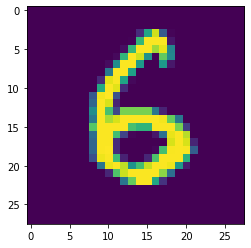

tensor(0)


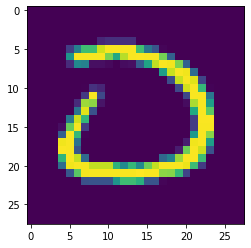

tensor(5)


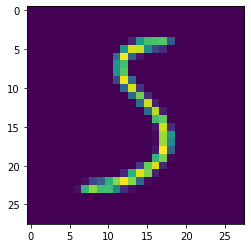

In [ ]:
# On visualise quelques chiffres manuscrits.
for data in train_loader:
    X, y = data
    images = X
    for i in range(3):
        print(y[i])
        plt.imshow(images[i].reshape(28,28))
        plt.show()
    break

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Définition de modèles initiaux et d'entraînement</font>**

Pour commencer, nous allons utiliser le modèle le plus simple : un réseau de neurone (classique) avec une seule couche connectée. Le modèle prend comme hyperparamètre la taille de la couche cachée.

Avec la librairie PyTorch, on définit notre modèle sous forme de classe Python (qui hérite de la classe `nn.Module`). On ajoute des couches dans la méthode `__init__()` en utilisant les fonctions fournies par PyTorch telle que `nn.Linear` (pour une couche entièrement connectée) et, enfin, dans la méthode `forward()`, on fait passer nos données à travers toutes les couches.

In [ ]:
class SingleLayerNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_in = nn.Linear(28*28, hidden_size)
        self.linear_out = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.linear_in(x)
        x = self.linear_out(x)
        return F.log_softmax(x, dim=1)

Pour l'entraînement du modèle, il faut instancier le modèle lui-même, un critère d'optimisation (fonction de perte) et un algorithme d'optimisation (tel que la descente de gradient stochastique, soit SGD).

Avant de commencer, assurez-vous d'avoir mis votre notebook Colab en mode GPU, ce qui accélère énormément l'entraînement.

*Edit > Notebook Settings > Hardware Accelerator > Choisir l'option « GPU »*


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SingleLayerNN(hidden_size=64)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Il est également possible de définir certains hyperparamètres, comme le nombre d'itérations, à travers l'ensemble des données. Nous désirons aussi sauvegarder la perte sur l'ensemble d'entraînement **et** sur l'ensemble de validation après chaque itération, donc des variables ont été initialisées ici à cet effet.

In [ ]:
N_EPOCHS = 5

train_losses = []
valid_losses = []

Dans chaque *epoch* (itération à travers l'ensemble des données), on fait passer au modèle un lot (*batch*) de données à la fois jusqu'à ce que toutes les données aient été vues.

Le processus d'entraînement se passe ainsi :


*   On donne un lot de données au modèle.
*   La prédiction du modèle est comparée aux vraies valeurs pour produire une valeur de perte (qui est sommée dans une autre variable).
*   On rétropropage les gradients par rapport à la perte et on les met à jour avec l'algorithme d'optimisation.

Enfin, après chaque *epoch*, on va aussi calculer cette perte, mais sur l'ensemble de validation, ce qui nous permet d'évaluer la capacité de généralisation du modèle.


In [ ]:
def train(cnn=True):
    for epoch in range(N_EPOCHS):
        current_loss = 0.0
        for data in train_loader:
            X, y = data
            # Mettre les données sur GPU.
            X = X.to(device)
            y = y.to(device)

            # Si le réseau n'est pas convolutionnel, on aplatit les 784 pixels
            # dans un image en une dimension.
            if not cnn:
                X = X.reshape(X.shape[0], -1)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
        current_loss /= len(train_loader)
        train_losses.append(current_loss)

        # On imprime les pertes après chaque epoch et on sauvegarde aussi ces valeurs.
        print(f"Epoch {epoch}:")
        print(f"Training loss: {current_loss}")
        with torch.no_grad():
            valid_loss = 0.0
            for data in valid_loader:
                X, y = data
                X = X.to(device)
                y = y.to(device)

                if not cnn:
                    X = X.reshape(X.shape[0], -1)
                optimizer.zero_grad()

                output = model(X)
                loss = criterion(output, y)

                valid_loss += loss.item()
            valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        print(f"Validation loss: {valid_loss}")

train(cnn=False)

Epoch 0:
Training loss: 1.7558767790543406
Validation loss: 1.270868022441864
Epoch 1:
Training loss: 0.9703325524037344
Validation loss: 0.7919445709387462
Epoch 2:
Training loss: 0.6764976428057018
Validation loss: 0.6224269125858942
Epoch 3:
Training loss: 0.5560182413772533
Validation loss: 0.538919552564621
Epoch 4:
Training loss: 0.49107870532755266
Validation loss: 0.4902314013242722


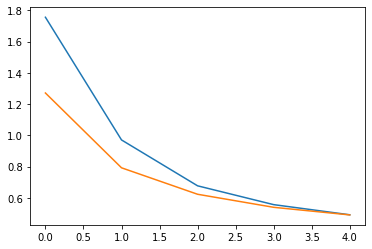

In [ ]:
# Graphique des pertes après chaque epoch.
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [ ]:
# On calcule la précision du modèle final en utilisant l'ensemble de test.
def test(cnn=True):
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        for data in test_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)

            if not cnn:
                X = X.reshape(X.shape[0], -1)

            output = model(X)
            correct_predictions += (y == torch.max(output, 1)[1]).sum()
        correct_predictions = int(correct_predictions) / len(test_data) * 100
    model.train()
    print(f"La précision du modèle final est de {correct_predictions}%")

test(cnn=False)

La précision du modèle final est de 88.5%


On va maintenant utiliser un modèle qui convient mieux aux données d'images : un réseau de neurones convolutionnel (CNN). La procédure d'entraînement est le même, mais on devrait obtenir de meilleurs résultats avec le même nombre d'époques d'entraînement.

In [ ]:
# Deuxième modèle : CNN simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4)
        )
        self.linear = nn.Linear(4*7*7,10)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# Entraînement
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []

train()

Epoch 0:
Training loss: 0.8986016043968368
Validation loss: 0.5499900609254837
Epoch 1:
Training loss: 0.4382050721817895
Validation loss: 0.4042638477683067
Epoch 2:
Training loss: 0.34536487820117096
Validation loss: 0.3440037141740322
Epoch 3:
Training loss: 0.2973778756028205
Validation loss: 0.3049307235702872
Epoch 4:
Training loss: 0.2669022177176125
Validation loss: 0.276808542261521


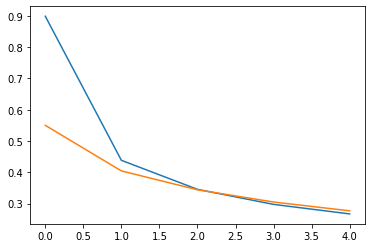

La précision du modèle final est de 92.93%


In [ ]:
# Évaluation
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

test()

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Modèle CNN avec données différentes</font>**

Maintenant, avec notre modèle CNN, nous avons eu une précision de plus de 90 % sur les données de test après seulement une minute d'entraînement! Mais, il faut admettre que les chiffres MNIST sont des images plutôt simples. Et si on entraînait ce même modèle sur des images plus complexes?

In [ ]:
# Télécharger le jeu de données CIFAR-10.

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
     ])

batch_size = 4

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_data, valid_data = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


CIFAR-10 est un ensemble de 60 000 images colorées de 32x32 pixels avec 10 classes d'objets.
![cifar10.png](https://drive.google.com/uc?export=view&id=1IlJpZZbm_i9jKQG-BJOoX5b8TaSmUOOE)

Source : https://www.cs.toronto.edu/~kriz/cifar.html

Comme avec MNIST, il serait utile de comprendre le format des données.

In [ ]:
for data in train_loader:
    print(type(data), len(data))
    X, y = data
    print(X.shape)
    print(y.shape)
    break

<class 'list'> 2
torch.Size([4, 3, 32, 32])
torch.Size([4])


Nous allons donc maintenant entraîner notre premier modèle (SimpleCNN) avec ces données CIFAR-10. Le code d'entraînement est le même, mais il faut faire quelques modifications au modèle pour prendre en compte la taille des nouvelles données.

In [ ]:
# Même modèle qu'avant, mais on ajuste certains paramètres pour assurer que les
# tailles correspondent à CIFAR-10 (3x32x32 au lieu de 1x28x28).
model = SimpleCNN()

# La couche d'entrée prend « 3 chaînes » de couleurs (RGB) à la place d'une (1) seule (noir et blanc).
model.cnn_layers[0] = nn.Conv2d(3, 4, kernel_size=2, stride=1, padding=1)

# Chaque image est un peu plus grande (32x32 au lieu de 28x28).
# Donc, la taille de sortie des couches CNN est un peu plus grande aussi.
model.linear = nn.Linear(256,10)

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_losses = []
valid_losses = []

train()

Epoch 0:
Training loss: 1.8119422411945132
Validation loss: 1.6770988750934601
Epoch 1:
Training loss: 1.6082456102079816
Validation loss: 1.6107928565263747
Epoch 2:
Training loss: 1.5588551909605661
Validation loss: 1.568050538110733
Epoch 3:
Training loss: 1.527106058910158
Validation loss: 1.5425942437529563
Epoch 4:
Training loss: 1.509767417436176
Validation loss: 1.5273861345529556


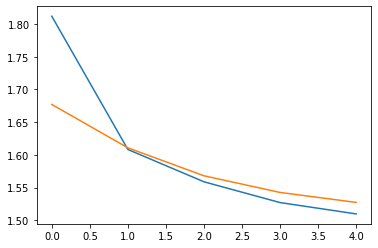

La précision du modèle final est de 49.120000000000005%


In [ ]:
# Évaluation du modèle final.
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

test()

Il est maintenant clair que notre modèle initial avec une seule couche convolutionnelle n'est plus suffisant face à ces nouvelles données! Ceci malgré le fait que cet entraînement a dû prendre notamment plus de temps que les cas précédents.

# <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> **<font color = "3832ba" face="Times New Roman" size=6>Modèle préentraîné</font>**

En pratique, on a souvent recours aux modèles préentraînés : on télécharge les poids d'un modèle (complexe) qui a déjà été entraîné sur nos données (ou souvent sur des données différentes).

## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=5>Code pour télécharger le modèle préentraîné (pas besoin de lire cette partie)</font>

Source : https://github.com/huyvnphan/PyTorch_CIFAR10

In [ ]:
!curl -sLS https://github.com/huyvnphan/PyTorch_CIFAR10/archive/refs/heads/master.zip > master.zip
!unzip master.zip
!rm master.zip
!mv -v PyTorch_CIFAR10-master/* ./
!rm -rf PyTorch_CIFAR10-master/

Archive:  master.zip
641cac24371b17052b9bb6e56af1c83b5e97cd7f
   creating: PyTorch_CIFAR10-master/
  inflating: PyTorch_CIFAR10-master/.gitignore  
  inflating: PyTorch_CIFAR10-master/LICENSE  
  inflating: PyTorch_CIFAR10-master/README.md  
   creating: PyTorch_CIFAR10-master/cifar10_models/
  inflating: PyTorch_CIFAR10-master/cifar10_models/densenet.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/googlenet.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/inception.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/mobilenetv2.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/resnet.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/resnet_orig.py  
  inflating: PyTorch_CIFAR10-master/cifar10_models/vgg.py  
  inflating: PyTorch_CIFAR10-master/data.py  
  inflating: PyTorch_CIFAR10-master/module.py  
  inflating: PyTorch_CIFAR10-master/schduler.py  
  inflating: PyTorch_CIFAR10-master/train.py  
renamed 'PyTorch_CIFAR10-master/cifar10_models' -> './cifar

In [ ]:
from data import CIFAR10Data
CIFAR10Data.download_weights()

100%|██████████| 979M/979M [00:46<00:00, 21.0MMiB/s]


Download successful. Unzipping file...
Unzip file successful!


## <img align="center" src="https://drive.google.com/uc?export=view&id=1HjAM7KY8wrX73rl0F_aOnK5Z-vwwsCrX" alt="drawing" width="100"/> <font color = "3832ba" face="Times New Roman" size=5>Utiliser le modèle préentraîné</font>

In [ ]:
from cifar10_models.vgg import vgg19_bn
model = vgg19_bn(pretrained=True)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Les poids de ce modèle ont déjà été téléchargés, donc il n'est pas nécessaire d'entraîner ce modèle. Vous pouvez voir l'architecture du modèle en question, VGG19, en faisant [une recherche sur Google](https://www.google.com/search?q=vgg19&tbm=isch).

In [ ]:
# Évaluation : il n'y a plus de courbe d'entraînement, car on n'a pas entraîné de modèle!
test()

La précision du modèle final est de 93.63%


Ce modèle en particulier a été entraîné sur les images CIFAR-10, le même jeu de données que nous avons utilisé. Par contre, il est aussi possible d'utiliser un modèle ayant été préentraîné sur d'autres données différentes, et, ensuite, de l'ajuster pour nos données afin d'obtenir une meilleure performance.